<a href="https://colab.research.google.com/github/carlosbrigida/cbic2025_python/blob/main/DeepLearningClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Clustering Methods applied in Passive Sonar Signals

Notebook para o treinamento e desenvolvimento de um artigo em clusterização de sinais de sonar passivo utilizando técnicas de aprendizado profundo

## Carga de bibliotecas

In [ ]:
import warnings
from scipy.signal import decimate, hanning, convolve, spectrogram, lfilter, cheby2, butter, cheb2ord, hilbert
from librosa import stft, fft_frequencies, frames_to_time
import numpy as np
import math

# biblioteca com as análises já implementadas
# não utilizei pois preferi fazer abertas caso precise mudar
#!pip install git+https://github.com/pedrolisboa/poseidon.git

## Definição de Funções auxiliares

In [ ]:
def tpsw(signal, npts=None, n=None, p=None, a=None):
    x = np.copy(signal)
    if x.ndim == 1:
        x = x[:, np.newaxis]
    if npts is None:
        npts = x.shape[0]
    if n is None:
        n=int(round(npts*.04/2.0+1))
    if p is None:
        p =int(round(n / 8.0 + 1))
    if a is None:
        a = 2.0
    if p>0:
        h = np.concatenate((np.ones((n-p+1)), np.zeros(2 * p-1), np.ones((n-p+1))), axis=None)
    else:
        h = np.ones((1, 2*n+1))
        p = 1
    h /= np.linalg.norm(h, 1)

    def apply_on_spectre(xs):
        return convolve(h, xs, mode='full')

    mx = np.apply_along_axis(apply_on_spectre, arr=x, axis=0)
    ix = int(np.floor((h.shape[0] + 1)/2.0)) # Defasagem do filtro
    mx = mx[ix-1:npts+ix-1] # Corrige da defasagem
    # Corrige os pontos extremos do espectro
    ixp = ix - p
    mult=2*ixp/np.concatenate([np.ones(p-1)*ixp, range(ixp,2*ixp + 1)], axis=0)[:, np.newaxis] # Correcao dos pontos extremos
    mx[:ix,:] = mx[:ix,:]*(np.matmul(mult, np.ones((1, x.shape[1])))) # Pontos iniciais
    mx[npts-ix:npts,:]=mx[npts-ix:npts,:]*np.matmul(np.flipud(mult),np.ones((1, x.shape[1]))) # Pontos finais
    #return mx
    # Elimina picos para a segunda etapa da filtragem
    #indl= np.where((x-a*mx) > 0) # Pontos maiores que a*mx
    indl = (x-a*mx) > 0
    #x[indl] = mx[indl]
    x = np.where(indl, mx, x)
    mx = np.apply_along_axis(apply_on_spectre, arr=x, axis=0)
    mx=mx[ix-1:npts+ix-1,:]
    #Corrige pontos extremos do espectro
    mx[:ix,:]=mx[:ix,:]*(np.matmul(mult,np.ones((1, x.shape[1])))) # Pontos iniciais
    mx[npts-ix:npts,:]=mx[npts-ix:npts,:]*(np.matmul(np.flipud(mult),np.ones((1,x.shape[1])))) # Pontos finais

    if signal.ndim == 1:
        mx = mx[:, 0]
    return mx

def lofar(data, fs, n_pts_fft=1024, n_overlap=0,
          spectrum_bins_left=None, **tpsw_args):

    if not isinstance(data, np.ndarray):
        raise NotImplementedError

    freq, time, power = spectrogram(data,
                                    window=('hann'),
                                    nperseg=n_pts_fft,
                                    noverlap=n_overlap,
                                    nfft=n_pts_fft,
                                    fs=fs,
                                    detrend=False,
                                    axis=0,
                                    scaling='spectrum',
                                    mode='magnitude')
    #For stereo, without further changes, the genreated spectrogram has shape (freq, channel, time)
    if power.ndim == 3: # temporary fix for stereo audio.
        power = power.mean(axis=1)
        power = power.squeeze()

    power = np.absolute(power)
    power = power / tpsw(power)#, **tpsw_args)
    power = np.log10(power)
    power[power < -0.2] = 0

    if spectrum_bins_left is None:
        spectrum_bins_left = power.shape[0]*0.8
    power = power[:spectrum_bins_left, :]
    freq = freq[:spectrum_bins_left]

    return np.transpose(power), freq, time


def demon(data, fs, n_fft=1024, max_freq=35, overlap_ratio=0.5, apply_bandpass=True, bandpass_specs=None, method='abs'):
    if not isinstance(data, np.ndarray):
        raise ValueError("Input must be of type numpy.ndarray. %s was passed" % type(data))
    x = data.copy()

    first_pass_sr = 1250 # 31250/25

    q1 = round(fs/first_pass_sr) # 25 for 31250 sample rate ; decimatio ratio for 1st pass
    q2 = round((fs/q1)/(2*max_freq)) # decimatio ratio for 2nd pass

    fft_over = math.floor(n_fft-2*max_freq*overlap_ratio)

    if apply_bandpass:
        if bandpass_specs is None:
            nyq = fs/2
            wp = [1000/nyq, 2000/nyq]
            ws = [700/nyq, 2300/nyq]
            rp = 0.5
            As = 50
        elif isinstance(bandpass_specs, dict):
            try:
                fp = bandpass_specs["fp"]
                fs = bandpass_specs["fs"]

                wp = np.array(fp)/nyq
                ws = np.array(fs)/nyq

                rp = bandpass_specs["rs"]
                As = bandpass_specs["as"]
            except KeyError as e:
                raise KeyError("Missing %s specification for bandpass filter" % e)
        else:
            raise ValueError("bandpass_specs must be of type dict. %s was passed" % type(bandpass_specs))

        N, wc = cheb2ord(wp, ws, rp, As)
        b, a = cheby2(N, rs=As, Wn=wc, btype='bandpass', output='ba', analog=True)
        x = lfilter(b, a, x, axis=0)

    if method=='hilbert':
        x = hilbert(x)
    elif method=='abs':
        x = np.abs(x) # demodulation
    else:
        raise ValueError("Method not found")

    x = decimate(x, q1, ftype='fir', zero_phase=False)
    x = decimate(x, q2, ftype='fir', zero_phase=False)

    final_fs = (fs//q1)//q2

    x /= x.max()
    x -= np.mean(x)
    sxx = stft(x,
               window=('hann'),
               win_length=n_fft,
               hop_length=(n_fft - fft_over),
               n_fft=n_fft)
    freq = fft_frequencies(sr=final_fs, n_fft=n_fft)
    time = frames_to_time(np.arange(0, sxx.shape[1]),
                   sr=final_fs, hop_length=(n_fft - fft_over))

    sxx = np.absolute(sxx)

    sxx = sxx / tpsw(sxx)

    sxx, freq = sxx[8:, :], freq[8:] # ??

    return np.transpose(sxx), freq, time

## Carga de dados e análise LOFAR

In [ ]:
# todos os dados que vou utilizar estão no meu drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from os import walk

file_folder = "/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/"
database = "4classes_old"

file_path = os.path.join(file_folder, database)

dict_classes = {} # dicionario com todos os nomes dos arquivos organizados

f = []
for (dirpath, dirnames, filenames) in walk(top=file_path,topdown=True):
    if filenames == []: # lista de arquivos vazia
      continue
    filenames.sort()
    dict_classes[dirpath.split('/')[-1]] = {}
    for filename in filenames:
      dict_classes[dirpath.split('/')[-1]][filename.split('.')[0]] = os.path.join(dirpath,filename)

In [ ]:
dict_classes

{'ClassA': {'navio10': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassA/navio10.wav',
  'navio11': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassA/navio11.wav',
  'navio12': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassA/navio12.wav',
  'navio13': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassA/navio13.wav',
  'navio14': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassA/navio14.wav'},
 'ClassB': {'navio20': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassB/navio20.wav',
  'navio21': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassB/navio21.wav',
  'navio22': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassB/navio22.wav',
  'navio23': '/content/drive/MyDrive/Work/UFRJ/Projetos/Marinha/Dados/4classes_old/ClassB/navio23.wav',
  'navio24': '/content/drive/MyDrive/Work/U

In [ ]:
# célula onde eu faço a análise lofar

import soundfile as sf
import pandas as pd

df_all_data = None

for iclass in dict_classes.keys():
  for irun in dict_classes[iclass].keys():
    df_run = pd.DataFrame()
    signal, fs = sf.read(dict_classes[iclass][irun])
    lofar_signal, freq, time = lofar(data=signal,fs=fs, n_pts_fft=1024,
                         n_overlap=0.0, spectrum_bins_left=400)
    print('Processing Class: %s - Run: %s'%(iclass,irun))
    df_run['fs'] = fs*np.ones([lofar_signal.shape[0]])
    df_run['filename'] = dict_classes[iclass][irun]
    df_run['run'] = irun
    df_run['class'] = iclass
    df_lofar_signal = pd.DataFrame(lofar_signal)
    df_lofar_signal = df_lofar_signal.add_prefix('bin_')
    df_run = pd.concat([df_run, df_lofar_signal], axis=1)
    if df_all_data is None:
      df_all_data = df_run
    else:
      df_all_data = pd.concat([df_all_data,df_run],axis=0, ignore_index=True)

Processing Class: ClassA - Run: navio10
Processing Class: ClassA - Run: navio11
Processing Class: ClassA - Run: navio12
Processing Class: ClassA - Run: navio13
Processing Class: ClassA - Run: navio14
Processing Class: ClassC - Run: navio30
Processing Class: ClassC - Run: navio31
Processing Class: ClassC - Run: navio32
Processing Class: ClassC - Run: navio33
Processing Class: ClassC - Run: navio34
Processing Class: ClassC - Run: navio35
Processing Class: ClassC - Run: navio37
Processing Class: ClassC - Run: navio38
Processing Class: ClassC - Run: navio39
Processing Class: ClassB - Run: navio20
Processing Class: ClassB - Run: navio21
Processing Class: ClassB - Run: navio22
Processing Class: ClassB - Run: navio23
Processing Class: ClassB - Run: navio24
Processing Class: ClassB - Run: navio25
Processing Class: ClassB - Run: navio26
Processing Class: ClassB - Run: navio27
Processing Class: ClassB - Run: navio28
Processing Class: ClassB - Run: navio29
Processing Class: ClassD - Run: navio40


In [ ]:
# esse é o valor do dx para calculo da área embaixo do histograma
print(freq[1]-freq[0])
print(freq[21]-freq[20])
dx = freq[1]-freq[0]

21.533203125
21.533203125


In [ ]:
# adicionando a coluna target
classes = df_all_data['class'].unique()
classes.sort()
df_all_data['target']=-1
for iclass, class_value in enumerate(classes):
  df_all_data.loc[df_all_data['class']==class_value,'target']=iclass

# criando uma chave única por janela
df_all_data['window_id'] = df_all_data.index

In [ ]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,bin_392,bin_393,bin_394,bin_395,bin_396,bin_397,bin_398,bin_399,target,window_id
0,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.000000,0.000000,-0.095023,0.207849,0.172270,0.000000,-0.188387,0.000000,0,0
1,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,0.110898,-0.092722,-0.038747,0.113801,-0.152823,-0.117272,0.163662,0.137150,0,1
2,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,0.117354,0.000000,0.000000,-0.189164,0.032740,0.303563,0.275072,-0.017150,0,2
3,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.146549,-0.115717,0.174938,0.124910,0.111019,0.109464,-0.177160,-0.017336,0,3
4,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,-0.176851,0.015273,0.319997,0.069744,-0.189101,0.056269,0.000000,-0.048143,0,4


In [ ]:
df_all_data.tail()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,bin_392,bin_393,bin_394,bin_395,bin_396,bin_397,bin_398,bin_399,target,window_id
77556,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio49,ClassD,0.0,0.000000,0.134582,0.350596,0.482120,0.128518,...,0.019014,-0.028376,0.000000,-0.142719,0.111855,0.000000,0.123593,0.000000,3,77556
77557,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio49,ClassD,0.0,0.000000,0.047840,0.549740,0.315425,0.421357,...,0.067997,0.054851,-0.143025,0.000000,0.159218,0.341742,0.105383,0.000000,3,77557
77558,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio49,ClassD,0.0,-0.185597,0.116965,0.230601,0.291896,0.282431,...,0.251547,-0.192838,-0.046801,0.000000,0.060910,0.182108,-0.124501,0.000000,3,77558
77559,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio49,ClassD,0.0,0.000000,-0.197215,0.507435,0.526446,0.000000,...,0.383202,0.265755,0.228227,0.210201,-0.057612,0.000000,0.000000,0.000000,3,77559
77560,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio49,ClassD,0.0,0.000000,0.000000,0.000000,0.197386,0.179800,...,0.000000,0.007365,0.293251,0.316163,0.192700,0.109876,0.147825,-0.197342,3,77560


### Apresentando o resultado da Análise Lofar

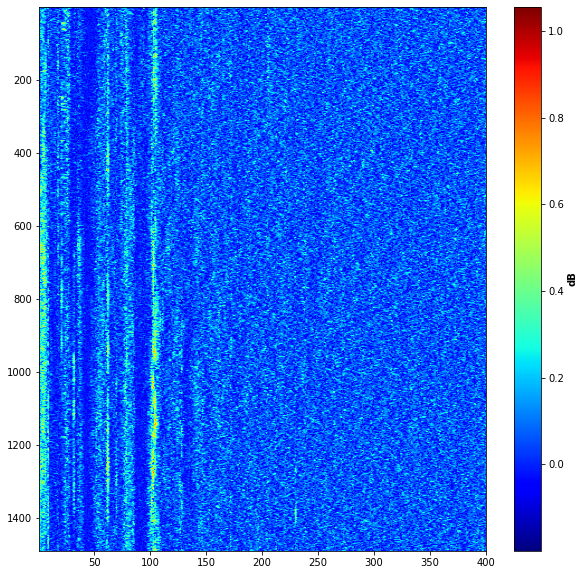

In [ ]:
# Selecionando uma run
import matplotlib.pyplot as plt
selected_run = 'navio30'
fig, ax= plt.subplots(figsize=(10,10))
plot_data = df_all_data[df_all_data['run']==selected_run].filter(like='bin_').values
plt.imshow(plot_data,
           cmap="jet",extent=[1, 400, plot_data.shape[0],1],
           aspect="auto")
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB',fontweight='bold');

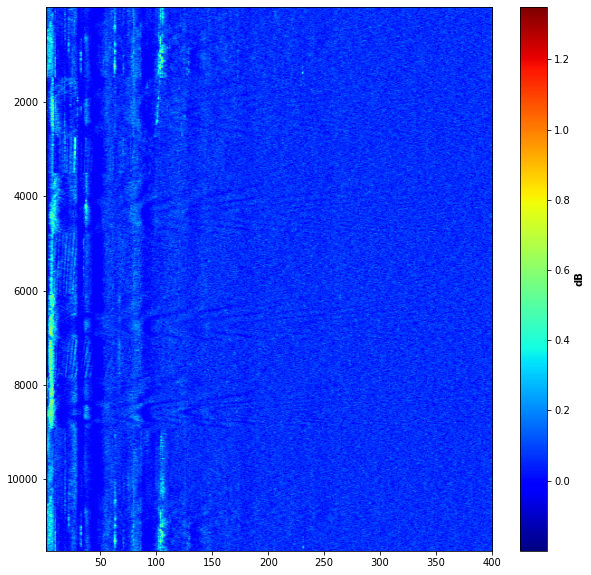

In [ ]:
# Selecionando uma classe
selected_class = 'ClassC'
fig, ax= plt.subplots(figsize=(10,10))
plot_data = df_all_data[df_all_data['class']==selected_class].filter(like='bin_').values
plt.imshow(plot_data,
           cmap="jet",extent=[1, 400, plot_data.shape[0],1],
           aspect="auto")
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB',fontweight='bold');

## Validação cruzada

### Validação cruzada por janela

A validação cruzada por janela é a validação cruzada mais aleatória que podemos fazer no caso de uma aplicação de sonar passivo, mas, infelizmente, ela mistura diferentes condições de máquina numa mesmo fold. Isso pode fazer com que os resultados dos modelos sejam enviezados e estamos começando a ambandonar esse método de avaliação


Aqui vamos utilizar os alvos estratificados para eventualmente fazemos uma normalização com pesos nos modelos

Variáveis booleanas estão presentes no banco para indicar quais janelas foram selecionadas para treino (**window_cv_is_train_fold_X**), para validação (**window_cv_is_valid_fold_X**) e para teste (**window_cv_is_test**)

In [ ]:
# seleção do conjunto de teste - conjunto nunca visto durante o processo de desenvolvimento
from sklearn.model_selection import StratifiedKFold

trgt = df_all_data['target'].values
data = df_all_data.filter(like='bin_').values

df_all_data['window_cv_is_test'] = 0

skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(data, trgt):
  df_all_data.loc[test_index,'window_cv_is_test'] = 1.0
  break

In [ ]:
# seleção dos conjuntos de desenvolvimento - conjuntos que podem permutar durante o desenvolvimento
from sklearn.model_selection import StratifiedKFold

n_folds = 10

df_dev_data = df_all_data[df_all_data['window_cv_is_test'] == 0].copy(deep=True)
df_dev_data.reset_index(inplace=True)


trgt = df_dev_data['target'].values
data = df_dev_data.filter(like='bin_').values

df_dev_data = df_dev_data.loc[:, ['window_id']]

skf = StratifiedKFold(n_splits=n_folds)

for ifold,(train_index, valid_index) in enumerate(skf.split(data, trgt)):
  df_dev_data['window_cv_is_train_fold_%i'%(ifold)] = 0
  df_dev_data['window_cv_is_valid_fold_%i'%(ifold)] = 0

  df_dev_data.loc[train_index,'window_cv_is_train_fold_%i'%(ifold)] = 1.0
  df_dev_data.loc[valid_index,'window_cv_is_valid_fold_%i'%(ifold)] = 1.0


df_all_data = df_all_data.merge(df_dev_data, how='outer', on='window_id')

df_all_data.fillna(0,inplace=True)

In [ ]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,window_cv_is_train_fold_5,window_cv_is_valid_fold_5,window_cv_is_train_fold_6,window_cv_is_valid_fold_6,window_cv_is_train_fold_7,window_cv_is_valid_fold_7,window_cv_is_train_fold_8,window_cv_is_valid_fold_8,window_cv_is_train_fold_9,window_cv_is_valid_fold_9
0,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Validação cruzada por corrida

Já a validação por corrida se aproxima mais da aplicação real de um sonar passivo. Aqui, temos diferentes corridas sendo utilizadas para o desenvolvimento, ou seja, não misturamos todas as  diferentes condições de máquina quando vamos gerar os conjuntos de desenvolvimento.

Aqui vamos utilizar os alvos estratificados para eventualmente fazemos uma normalização com pesos nos modelos

Variáveis booleanas estão presentes no banco para indicar quais janelas foram selecionadas para treino (**run_cv_is_train_fold_X**), para validação (**run_cv_is_valid_fold_X**) e para teste (**run_cv_is_test**)

In [ ]:
# seleção do conjunto de teste - conjunto de corridas nunca visto durante o processo de desenvolvimento

from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

data = []
trgt = []
for iclass, class_label in enumerate(dict_classes.keys()):
  for irun in dict_classes[class_label].keys():
    data.append(irun)
    trgt.append(iclass)

for train_index, test_index in rskf.split(data, trgt):
    if len(test_index) > 3:
      selected_4_test = [data[index] for index in test_index]
      #print(selected_4_test)
      break

df_all_data['run_cv_is_test'] = 0

for irun in selected_4_test:
  #print('irun: ',irun)
  df_all_data.loc[df_all_data['run']==irun,'run_cv_is_test'] = 1.0

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  UserWarning,


In [ ]:
# seleção dos conjuntos de desenvolvimento - conjuntos que podem permutar durante o desenvolvimento
from sklearn.model_selection import StratifiedKFold

n_folds = 10

df_dev_data = df_all_data[df_all_data['run_cv_is_test'] == 0].copy(deep=True)
df_dev_data.reset_index(inplace=True)


trgt = df_dev_data['target'].values
data = df_dev_data.filter(like='bin_').values

df_dev_data = df_dev_data.loc[:, ['window_id']]

skf = StratifiedKFold(n_splits=n_folds)

for ifold,(train_index, valid_index) in enumerate(skf.split(data, trgt)):
  df_dev_data['run_cv_is_train_fold_%i'%(ifold)] = 0
  df_dev_data['run_cv_is_valid_fold_%i'%(ifold)] = 0

  df_dev_data.loc[train_index,'run_cv_is_train_fold_%i'%(ifold)] = 1.0
  df_dev_data.loc[valid_index,'run_cv_is_valid_fold_%i'%(ifold)] = 1.0

df_all_data = df_all_data.merge(df_dev_data, how='outer', on='window_id')

df_all_data.fillna(0,inplace=True)

In [ ]:
list(df_all_data.columns)

['fs',
 'filename',
 'run',
 'class',
 'bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'bin_5',
 'bin_6',
 'bin_7',
 'bin_8',
 'bin_9',
 'bin_10',
 'bin_11',
 'bin_12',
 'bin_13',
 'bin_14',
 'bin_15',
 'bin_16',
 'bin_17',
 'bin_18',
 'bin_19',
 'bin_20',
 'bin_21',
 'bin_22',
 'bin_23',
 'bin_24',
 'bin_25',
 'bin_26',
 'bin_27',
 'bin_28',
 'bin_29',
 'bin_30',
 'bin_31',
 'bin_32',
 'bin_33',
 'bin_34',
 'bin_35',
 'bin_36',
 'bin_37',
 'bin_38',
 'bin_39',
 'bin_40',
 'bin_41',
 'bin_42',
 'bin_43',
 'bin_44',
 'bin_45',
 'bin_46',
 'bin_47',
 'bin_48',
 'bin_49',
 'bin_50',
 'bin_51',
 'bin_52',
 'bin_53',
 'bin_54',
 'bin_55',
 'bin_56',
 'bin_57',
 'bin_58',
 'bin_59',
 'bin_60',
 'bin_61',
 'bin_62',
 'bin_63',
 'bin_64',
 'bin_65',
 'bin_66',
 'bin_67',
 'bin_68',
 'bin_69',
 'bin_70',
 'bin_71',
 'bin_72',
 'bin_73',
 'bin_74',
 'bin_75',
 'bin_76',
 'bin_77',
 'bin_78',
 'bin_79',
 'bin_80',
 'bin_81',
 'bin_82',
 'bin_83',
 'bin_84',
 'bin_85',
 'bin_86',
 'bin_87',
 'bi

In [ ]:
df_all_data.head()

,fs,filename,run,class,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,...,run_cv_is_train_fold_5,run_cv_is_valid_fold_5,run_cv_is_train_fold_6,run_cv_is_valid_fold_6,run_cv_is_train_fold_7,run_cv_is_valid_fold_7,run_cv_is_train_fold_8,run_cv_is_valid_fold_8,run_cv_is_train_fold_9,run_cv_is_valid_fold_9
0,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.285231,0.768789,0.024381,0.279054,0.085808,0.191522,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.158850,-0.048318,0.000000,0.318415,0.256691,0.371016,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.005624,0.029566,0.244969,0.292397,0.333643,-0.042749,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.000000,0.025384,0.409572,0.000000,0.362182,0.351990,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,22050.0,/content/drive/MyDrive/Work/UFRJ/Projetos/Mari...,navio10,ClassA,0.936074,0.962354,0.594510,0.000000,0.061220,-0.115332,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Modelagem de Dados

In [ ]:
model_path = '/content/drive/MyDrive/Work/UFRJ/Artigos/Deep Learning Clustering Methods Applied in Passive Sonar Systems/models'

### k-Means (baseline)

### Avaliação de Hiperparametros


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer

import logging

# load data & preprocess
cv_method = 'window'

input_data = df_all_data[df_all_data['%s_cv_is_test'%(cv_method)] == 1].copy(deep=True)
trgt_data = input_data['target'].values
input_data = input_data.filter(like='bin_').values

scaler = StandardScaler()
scaler.fit(input_data)
processed_data = scaler.transform(input_data)

hyperparams = {
    "random_state":[42],
    "n_clusters": np.arange(4,50),
    "n_init": [10, 15, 20],
    "max_iter": [100, 200, 300, 400, 500],
    "tol": [.0000001, .000001, .00001, .0001],
}

# hyperparams = {
#     "random_state":[42],
#     "n_clusters": np.arange(10,15,1),
#     "n_init": [1],
#     "max_iter": [100],
#     "tol": [.0001],
# }

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(input_data,trgt_data)
estimator = KMeans(init='k-means++', verbose=10)

logging.basicConfig(format="%(levelname)s:%(name)s: %(message)s",
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# silhouter score metrics as scorer
def silhouette_score(estimator, X):
    labels = estimator.fit_predict(X)
    try:
        score = silhouette_score(X, labels, metric='euclidean')
        # score = sklearn.metrics.calinski_harabasz_score(X, labels)
    except ValueError:
        score = -1
    return score

# GridSearchCV(cv=KFold(n_splits=3, random_state=50, shuffle=True),
#        error_score='raise',
#        estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
#     n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
#     random_state=None, tol=0.0001, verbose=0),
#        fit_params=None, iid=True, n_jobs=-1,
#        param_grid={'max_iter': [100, 200, 300, 400, 500], 'n_init': [10, 15, 20], 'tol': [1e-07, 1e-06, 1e-05, 0.0001], 'n_clusters': [2, 3]},
#        pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
#        scoring=None, verbose=0)
grid = GridSearchCV(estimator=estimator, param_grid=hyperparams, cv=cv, verbose=4,n_jobs=-1,)

grid.fit(input_data)

logger.info('best parameter {}: n_clusters {}'.format(grid.best_params_, len(np.unique(grid.best_estimator_.labels_))))


Fitting 10 folds for each of 2760 candidates, totalling 27600 fits


In [ ]:
grid.best_score_

-6633.593858819344

In [ ]:
grid.best_estimator_

KMeans(max_iter=100, n_clusters=14, n_init=1, random_state=42, verbose=10)

In [ ]:
logger

<Logger __main__ (INFO)>

#### Treinamento

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from joblib import dump, load

# base: https://realpython.com/k-means-clustering-python/
# base: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# base: https://machinelearningmastery.com/clustering-algorithms-with-python/
# para encontrar o joelho: https://github.com/arvkevi/kneed#installation

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

model_folder = os.path.join(model_path,database,'kmeans')
compress_level = 5 # half-way

min_clusters = 4
max_clusters = 30
delta_clusters = 1

cv_method = 'window'

# A list holds the SSE values for each k
sse = np.zeros([len(np.arange(n_folds)),len(np.arange(min_clusters, max_clusters+1, delta_clusters))])
for ifold in np.arange(n_folds):
  print('Processing fold ',ifold)

  # pre-process data
  input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
  input_data = input_data.filter(like='bin_').values
  scaler = StandardScaler()
  scaler.fit(input_data)
  processed_data = scaler.transform(input_data)

  for icluster in np.arange(min_clusters, max_clusters+1, delta_clusters):
    model_name = 'kmeans_%s_cv_%i_fold_%i_clusters.jbl'%(cv_method,ifold,icluster)
    print('Processing cluster: ',icluster)
    if not os.path.exists(os.path.join(model_folder,model_name)):
      print('Training...')
      kmeans = KMeans(n_clusters=icluster, **kmeans_kwargs)
      kmeans.fit(processed_data)
      dump(kmeans, os.path.join(model_folder,model_name))
      print('done')
    else:
      print('Model already trained...')

NameError: ignored

#### Definição de funções auxiliares

In [ ]:
# criar uma função que "pinta" os clusters de acordo com a ocorrência das classes!
def get_cluster_class_percentage(model, data, trgt):
  # agora preciso pintar os grupos gerados pelo modelo
  y_truth = trgt
  y_pred = model.predict(data)

  df_analysis = pd.DataFrame(np.array([y_truth, y_pred]).T, columns=['y_truth','y_pred'])

  perc_mat = np.zeros([len(np.unique(y_pred)),len(np.unique(y_truth))])

  for icluster in np.unique(y_pred): # rodando nos clusters estimados
    for iclass in np.unique(y_truth): # rodando nas classes
      #print((df_analysis[(df_analysis['y_pred']==icluster) & (df_analysis['y_truth']==iclass)].shape[0])/df_analysis[df_analysis['y_pred']==icluster].shape[0])
      perc_mat[icluster,iclass] = ((df_analysis[(df_analysis['y_pred']==icluster) & (df_analysis['y_truth']==iclass)].shape[0])/
                                  (df_analysis[df_analysis['y_pred']==icluster].shape[0]))
  return np.argmax(perc_mat,axis=1)


from scipy.integrate import simps
from numpy import trapz

def safe_sum(data):
  data[np.isinf(data)] = 0.0
  data[np.isnan(data)] = 0.0
  return np.sum(data)

def calc_spectrum_kl(spectrum_1, spectrum_2, area_method='trapz', dx=5):
  '''
    spectrum_1: estimated spectrum for data 1
    spectrum_2: estimated spectrum for data 2
    area_method: way to compute area, possible: trapz (trapezoidal rule) or simps (Simpson's rule)
    dx = frequency bin width
  '''
  # pego cada um dos espectros medidos normalizo e faço o calculo da KL neste ponto
  # retorno o valor obtido

  # area_1 = 0
  # if area_method == 'trapz':
  #   area_1 = trapz(spectrum_1, dx=dx)
  # elif area_method == 'simps':
  #   area_1 = simps(spectrum_1, dx=5)
  norm_spectrum_1 = spectrum_1#/area_1

  # area_2 = 0
  # if area_method == 'trapz':
  #   area_2 = trapz(spectrum_2, dx=dx)
  # elif area_method == 'simps':
  #   area_2 = simps(spectrum_2, dx=5)
  norm_spectrum_2 = spectrum_2#/area_2

  kl_1 = safe_sum(norm_spectrum_1*np.log10(norm_spectrum_1/norm_spectrum_2))
  #kl_2 = safe_sum(norm_spectrum_2*np.log10(norm_spectrum_2/norm_spectrum_1))

  return kl_1

def get_kl_div_mat(data, area_method='trapz', dx=5):
  kl_mat = np.zeros([data.shape[0], data.shape[0]])
  for idx, ifeature1 in enumerate(data):
    for idy, ifeature2 in enumerate(data):
      kl_mat[idx,idy] = calc_spectrum_kl(ifeature1,ifeature2,area_method=area_method, dx=dx)
  return kl_mat

from sklearn.metrics.pairwise import pairwise_distances

# pairwise distance calculation
# pt1
# From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’,
# ‘l1’, ‘l2’, ‘manhattan’]. These metrics support sparse matrix inputs.
# [‘nan_euclidean’] but it does not yet support sparse matrices.

# From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’,
# ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’,
# ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’,
# ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]

def get_intra_cluster_dist(model, data, method='euclidean', n_jobs=-1):
  y_pred = model.predict(data)

  df_funct = pd.DataFrame(data)
  df_funct = df_funct.add_prefix('bin_')
  df_funct['model'] = y_pred

  dist = np.zeros(len(np.unique(y_pred)))

  gb = df_funct.groupby(["model"])
  for idx, icluster in enumerate(np.unique(y_pred)):
    events = gb.get_group(icluster).values
    events = events[:,0:400]
    dist[idx] = np.mean(pairwise_distances(events.T, metric=method, n_jobs=n_jobs))

  return np.sum(dist)

def get_extra_cluster_dist(model, data, method='euclidean'):
  distance_matrix = pairwise_distances(model.cluster_centers_, metric=method)
  return np.sum(distance_matrix)

from sklearn.metrics import davies_bouldin_score
def get_davies_bouldin(model, data):
  y_pred = model.predict(data)
  return davies_bouldin_score(data, y_pred)

from sklearn.metrics import silhouette_score
def get_silhouette_score(model, data):
  y_pred = model.predict(data)
  return silhouette_score(data,y_pred)

def get_intra_cluster_kl(model, data, method='euclidean', n_jobs=-1):
  y_pred = model.predict(data)

  df_funct = pd.DataFrame(data)
  df_funct = df_funct.add_prefix('bin_')
  df_funct['model'] = y_pred

  dist = np.zeros(len(np.unique(y_pred)))

  gb = df_funct.groupby(["model"])
  for idx, icluster in enumerate(np.unique(y_pred)):
    events = gb.get_group(icluster).values
    events = events[:,0:400]
    dist[idx] = np.sum(get_kl_div_mat(events, area_method='trapz', dx=dx))

  return np.sum(dist)

def get_extra_cluster_kl(model, data, method='euclidean'):
  return np.sum(np.sum(get_kl_div_mat(model.cluster_centers_, area_method='trapz', dx=dx)))

# criar uma função que recebe os dados, recebe as informações dos modelos e calcula o resultado de classificação para os mesmos, tanto para validação quanto pra testes
# além disso, esta função expõe o resultado como uma tabela (preparando para colocar tudo no artigo)
def get_classification_report():
  return 0


#### Análise de um cluster

In [ ]:
import pandas as pd
from joblib import dump, load
from sklearn.metrics import precision_score, recall_score

cv_method = 'window'

icluster = 10

extra_cluster_dist = np.zeros(n_folds)
intra_cluster_dist = np.zeros(n_folds)
extra_cluster_kl = np.zeros(n_folds)
intra_cluster_kl = np.zeros(n_folds)
davies_bouldin_index = np.zeros(n_folds)
precision_micro_score = np.zeros(n_folds)
precision_weighted_score = np.zeros(n_folds)
recall_micro_score = np.zeros(n_folds)
recall_weighted_score = np.zeros(n_folds)


for ifold in np.arange(n_folds):
  print('Processing fold ',ifold)
  model_folder = os.path.join(model_path,database,'kmeans')

  # pre-process data
  input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
  trgt = input_data['target'].values
  input_data = input_data.filter(like='bin_').values
  scaler = StandardScaler()
  scaler.fit(input_data)
  processed_data = scaler.transform(input_data)

  model_name = 'kmeans_%s_cv_%i_fold_%i_clusters.jbl'%(cv_method,ifold,icluster)
  kmeans = load(os.path.join(model_folder,model_name))

  cluster2class = get_cluster_class_percentage(kmeans, processed_data, trgt)
  print('Cluster max class: ', cluster2class)

  extra_cluster_dist[ifold] = get_extra_cluster_dist(kmeans, processed_data)
  print('ExtraCluster distance: ', extra_cluster_dist[ifold])
  intra_cluster_dist[ifold] = get_intra_cluster_dist(kmeans, processed_data)
  print('IntraCluster distance: ', intra_cluster_dist[ifold])

  # demora muito!
  # extra_cluster_kl[ifold] = get_extra_cluster_kl(kmeans, processed_data)
  # print('ExtraCluster KL: ', extra_cluster_kl[ifold])
  # intra_cluster_kl[ifold] = get_intra_cluster_kl(kmeans, processed_data)
  # print('IntraCluster distance: ', intra_cluster_kl[ifold])

  davies_bouldin_index[ifold] = get_davies_bouldin(kmeans,processed_data)
  print('Davies Bouldin index: ', davies_bouldin_index[ifold])

  # demora muito!
  #print('Silhouette index: ', get_silhouette_score(kmeans,processed_data))

  # get "classification" result
  input_data = df_all_data
  input_data = input_data.filter(like='bin_').values
  processed_data = scaler.transform(input_data)
  y_pred = kmeans.predict(processed_data)
  y_class_pred = [cluster2class[value] for value in y_pred]
  df_all_data['kmeans_%s_cv_%i_fold_%i_clusters_predictions'%(cv_method,ifold,icluster)] = y_class_pred
  precision_weighted_score[ifold] = precision_score(df_all_data['target'].values, y_class_pred,average='weighted')
  print('Precision Score (weighted): ',precision_weighted_score[ifold])
  precision_micro_score[ifold] = precision_score(df_all_data['target'].values, y_class_pred,average='micro')
  print('Precision Score (micro): ',precision_micro_score[ifold])
  recall_weighted_score[ifold] = recall_score(df_all_data['target'].values, y_class_pred,average='weighted')
  print('Recall Score (weighted): ',recall_weighted_score[ifold])
  recall_micro_score[ifold] = recall_score(df_all_data['target'].values, y_class_pred,average='micro')
  print('Recall Score (micro): ',recall_micro_score[ifold])

print('\n\n')
print('For all folds')
print('ExtraCluster distance: ', np.mean(extra_cluster_dist), '+-', np.std(extra_cluster_dist))
print('IntraCluster distance: ', np.mean(intra_cluster_dist), '+-', np.std(intra_cluster_dist))
print('Davies Bouldin index: ', np.mean(davies_bouldin_index), '+-', np.std(davies_bouldin_index))

print('Precision Score (weighted): ',np.mean(precision_weighted_score), '+-', np.std(precision_weighted_score))
print('Precision Score (micro): ',np.mean(precision_micro_score), '+-', np.std(precision_micro_score))
print('Recall Score (weighted): ',np.mean(recall_weighted_score), '+-', np.std(recall_weighted_score))
print('Recall Score (micro): ',np.mean(recall_micro_score), '+-', np.std(recall_micro_score))

Processing fold  0
Cluster max class:  [3 0 2 1 0 3 1 1 3 3]
ExtraCluster distance:  489.28653838198653
IntraCluster distance:  1097.9138818324504
Davies Bouldin index:  9.272741139409863
Precision Score (weighted):  0.7148737706202777
Precision Score (micro):  0.70521267131677
Recall Score (weighted):  0.70521267131677
Recall Score (micro):  0.70521267131677
Processing fold  1
Cluster max class:  [3 3 3 2 0 1 1 0 1 3]
ExtraCluster distance:  494.28989405131273
IntraCluster distance:  1095.7028142033437
Davies Bouldin index:  9.14572324637346
Precision Score (weighted):  0.7192581721573087
Precision Score (micro):  0.7039104704684055
Recall Score (weighted):  0.7039104704684055
Recall Score (micro):  0.7039104704684055
Processing fold  2
Cluster max class:  [1 3 2 3 0 1 3 0 3 1]
ExtraCluster distance:  508.75819126191914
IntraCluster distance:  1090.4926346370542
Davies Bouldin index:  9.046860906725579
Precision Score (weighted):  0.7203594731198522
Precision Score (micro):  0.7032916

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Score (weighted):  0.5698013193421291
Precision Score (micro):  0.6515645749796934
Recall Score (weighted):  0.6515645749796934
Recall Score (micro):  0.6515645749796934



For all folds
ExtraCluster distance:  507.93153146720323 +- 9.820916234569339
IntraCluster distance:  1093.5555422002458 +- 3.531219817178545
Davies Bouldin index:  9.0628087829505 +- 0.11424388998625498
Precision Score (weighted):  0.7119499897436732 +- 0.048455738145795575
Precision Score (micro):  0.7059759415169995 +- 0.0199553330661049
Recall Score (weighted):  0.7059759415169995 +- 0.0199553330661049
Recall Score (micro):  0.7059759415169995 +- 0.0199553330661049


#### Análise de diferentes clusters


In [ ]:
import pandas as pd
from joblib import dump, load
from sklearn.metrics import precision_score, recall_score

min_clusters = 4
max_clusters = 30
delta_clusters = 1

clusters = np.arange(min_clusters, max_clusters+1, delta_clusters)

mean_extra_cluster_dist = np.zeros([len(clusters)])
mean_intra_cluster_dist = np.zeros([len(clusters)])
mean_davies_bouldin_index = np.zeros([len(clusters)])
mean_precision_micro_score = np.zeros([len(clusters)])
mean_precision_weighted_score = np.zeros([len(clusters)])
mean_recall_micro_score = np.zeros([len(clusters)])
mean_recall_weighted_score = np.zeros([len(clusters)])

std_extra_cluster_dist = np.zeros([len(clusters)])
std_intra_cluster_dist = np.zeros([len(clusters)])
std_davies_bouldin_index = np.zeros([len(clusters)])
std_precision_micro_score = np.zeros([len(clusters)])
std_precision_weighted_score = np.zeros([len(clusters)])
std_recall_micro_score = np.zeros([len(clusters)])
std_recall_weighted_score = np.zeros([len(clusters)])


for idx, icluster in enumerate(clusters):
  extra_cluster_dist = np.zeros(n_folds)
  intra_cluster_dist = np.zeros(n_folds)
  davies_bouldin_index = np.zeros(n_folds)
  precision_micro_score = np.zeros(n_folds)
  precision_weighted_score = np.zeros(n_folds)
  recall_micro_score = np.zeros(n_folds)
  recall_weighted_score = np.zeros(n_folds)

  for ifold in np.arange(n_folds):
    print('Processing cluster ', icluster, ' fold ', ifold)
    model_folder = os.path.join(model_path,database,'kmeans')

    # pre-process data
    input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
    trgt = input_data['target'].values
    input_data = input_data.filter(like='bin_').values
    scaler = StandardScaler()
    scaler.fit(input_data)
    processed_data = scaler.transform(input_data)

    model_name = 'kmeans_%s_cv_%i_fold_%i_clusters.jbl'%(cv_method,ifold,icluster)
    kmeans = load(os.path.join(model_folder,model_name))

    cluster2class = get_cluster_class_percentage(kmeans, processed_data, trgt)
    extra_cluster_dist[ifold] = get_extra_cluster_dist(kmeans, processed_data)
    intra_cluster_dist[ifold] = get_intra_cluster_dist(kmeans, processed_data)
    davies_bouldin_index[ifold] = get_davies_bouldin(kmeans,processed_data)

    # get "classification" result
    input_data = df_all_data
    input_data = input_data.filter(like='bin_').values
    processed_data = scaler.transform(input_data)
    y_pred = kmeans.predict(processed_data)
    y_class_pred = [cluster2class[value] for value in y_pred]
    df_all_data['kmeans_%s_cv_%i_fold_%i_clusters_predictions'%(cv_method,ifold,icluster)] = y_class_pred
    precision_weighted_score[ifold] = precision_score(df_all_data['target'].values, y_class_pred,average='weighted')
    precision_micro_score[ifold] = precision_score(df_all_data['target'].values, y_class_pred,average='micro')
    recall_weighted_score[ifold] = recall_score(df_all_data['target'].values, y_class_pred,average='weighted')
    recall_micro_score[ifold] = recall_score(df_all_data['target'].values, y_class_pred,average='micro')
  mean_extra_cluster_dist[idx], std_extra_cluster_dist[idx] = np.mean(extra_cluster_dist), np.std(extra_cluster_dist)
  mean_intra_cluster_dist[idx], std_intra_cluster_dist[idx] = np.mean(intra_cluster_dist), np.std(intra_cluster_dist)
  mean_davies_bouldin_index[idx], std_davies_bouldin_index[idx] = np.mean(davies_bouldin_index), np.std(davies_bouldin_index)
  mean_precision_weighted_score[idx], std_precision_weighted_score[idx] = np.mean(precision_weighted_score), np.std(precision_weighted_score)
  mean_precision_micro_score[idx], std_precision_micro_score[idx] = np.mean(precision_micro_score), np.std(precision_micro_score)
  mean_recall_weighted_score[idx], std_recall_weighted_score[idx] = np.mean(recall_weighted_score), np.std(recall_weighted_score)
  mean_recall_micro_score[idx], std_recall_micro_score[idx] = np.mean(recall_micro_score), np.std(recall_micro_score)


Processing cluster  4  fold  0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  4  fold  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  5  fold  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  6  fold  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  7  fold  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  1
Processing cluster  8  fold  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  4
Processing cluster  8  fold  5
Processing cluster  8  fold  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  8  fold  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  9  fold  0
Processing cluster  9  fold  1
Processing cluster  9  fold  2
Processing cluster  9  fold  3
Processing cluster  9  fold  4
Processing cluster  9  fold  5
Processing cluster  9  fold  6
Processing cluster  9  fold  7
Processing cluster  9  fold  8
Processing cluster  9  fold  9
Processing cluster  10  fold  0
Processing cluster  10  fold  1
Processing cluster  10  fold  2
Processing cluster  10  fold  3
Processing cluster  10  fold  4
Processing cluster  10  fold  5
Processing cluster  10  fold  6
Processing cluster  10  fold  7
Processing cluster  10  fold  8
Processing cluster  10  fold  9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing cluster  11  fold  0
Processing cluster  11  fold  1
Processing cluster  11  fold  2
Processing cluster  11  fold  3
Processing cluster  11  fold  4
Processing cluster  11  fold  5
Processing cluster  11  fold  6
Processing cluster  11  fold  7
Processing cluster  11  fold  8
Processing cluster  11  fold  9
Processing cluster  12  fold  0
Processing cluster  12  fold  1
Processing cluster  12  fold  2
Processing cluster  12  fold  3
Processing cluster  12  fold  4
Processing cluster  12  fold  5
Processing cluster  12  fold  6
Processing cluster  12  fold  7
Processing cluster  12  fold  8
Processing cluster  12  fold  9
Processing cluster  13  fold  0
Processing cluster  13  fold  1
Processing cluster  13  fold  2
Processing cluster  13  fold  3
Processing cluster  13  fold  4
Processing cluster  13  fold  5
Processing cluster  13  fold  6
Processing cluster  13  fold  7
Processing cluster  13  fold  8
Processing cluster  13  fold  9
Processing cluster  14  fold  0
Processi

#### Plots

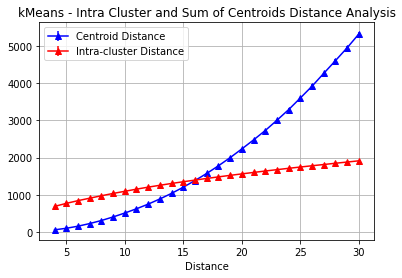

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.errorbar(clusters, mean_extra_cluster_dist, std_extra_cluster_dist,
             linestyle='-', marker='^', color='blue',label='Centroid Distance')
plt.errorbar(clusters, mean_intra_cluster_dist, std_intra_cluster_dist,
             linestyle='-', marker='^', color='red', label='Intra-cluster Distance')
plt.title('kMeans - Intra Cluster and Sum of Centroids Distance Analysis')
plt.xlabel('Number of Centroids')
plt.xlabel('Distance')
plt.grid()
plt.legend(loc='best')
plt.show()

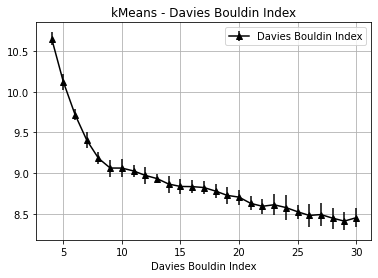

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.errorbar(clusters, mean_davies_bouldin_index, std_davies_bouldin_index,
             linestyle='-', marker='^', color='black',label='Davies Bouldin Index')
plt.title('kMeans - Davies Bouldin Index')
plt.xlabel('Number of Centroids')
plt.xlabel('Davies Bouldin Index')
plt.grid()
plt.legend(loc='best')
plt.show()

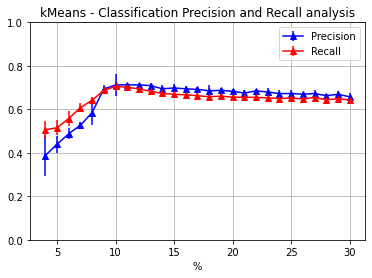

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.errorbar(clusters, mean_precision_weighted_score, std_precision_weighted_score,
             linestyle='-', marker='^', color='blue',label='Precision')
plt.errorbar(clusters, mean_recall_weighted_score, std_recall_weighted_score,
             linestyle='-', marker='^', color='red', label='Recall')
plt.title('kMeans - Classification Precision and Recall analysis')
plt.xlabel('Number of Centroids')
plt.xlabel('%')
plt.grid()
plt.legend(loc='best')
plt.ylim([0.0, 1.0])
plt.show()

### kMeans+PCA

### NMF scikit learn (baseline)

A minha primeira proposta de separação com NMF (scikit-learn) não funcionou! Acho que foi um problema de falta de controle da esparsidade. Eu tentei com o pacote NIMFA (pacote dedicado a NMF) mas também não gostei. Tenho que voltar aqui pra melhorar o treinamento. Por enquanto nada funcionou!



#### Treinamento

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import NMF
# from joblib import dump, load

# model_folder = os.path.join(model_path,database,'nmf')
# compress_level = 5 # half-way

# min_comp = 4
# max_comp = 20
# delta_comp = 1

# cv_method = 'window'

# for ifold in np.arange(n_folds):
#   print('Processing fold ',ifold)

#   # pre-process data
#   input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
#   input_data = input_data.filter(like='bin_').values
#   scaler = MinMaxScaler(feature_range=(0, 1))
#   scaler.fit(input_data)
#   processed_data = scaler.transform(input_data)

#   for icomp in np.arange(min_comp, max_comp+1, delta_comp):
#     model_name = 'nmf_%s_cv_%i_fold_%i_clusters.jbl'%(cv_method,ifold,icomp)
#     print('Processing comp: ',icomp)
#     if not os.path.exists(os.path.join(model_folder,model_name)):
#       print('Training...')
#       nmf = NMF(n_components=icomp, init='random', max_iter=500, random_state=0)
#       nmf.fit(processed_data)
#       dump(nmf, os.path.join(model_folder,model_name))
#       print('done')
#     else:
#       print('Model already trained...')

Processing fold  0
Processing comp:  4
Model already trained...
Processing comp:  5
Model already trained...
Processing comp:  6
Model already trained...
Processing comp:  7
Model already trained...
Processing comp:  8
Model already trained...
Processing comp:  9
Model already trained...
Processing comp:  10
Model already trained...
Processing comp:  11
Model already trained...
Processing comp:  12
Model already trained...
Processing comp:  13
Model already trained...
Processing comp:  14
Model already trained...
Processing comp:  15
Model already trained...
Processing comp:  16
Model already trained...
Processing comp:  17
Model already trained...
Processing comp:  18
Model already trained...
Processing comp:  19
Model already trained...
Processing comp:  20
Model already trained...
Processing fold  1
Processing comp:  4
Model already trained...
Processing comp:  5
Model already trained...
Processing comp:  6
Model already trained...
Processing comp:  7
Model already trained...
Proces

#### Definição de funções auxiliares

In [ ]:
# # criar uma função que "pinta" os componentes de acordo com a ocorrência das classes!
# def get_component_class_percentage(model, data, trgt):
#   # agora preciso pintar os grupos gerados pelo modelo
#   y_truth = trgt
#   transformed_data = model.transform(data)
#   y_pred = np.argmax(transformed_data,axis=1)

#   df_analysis = pd.DataFrame(np.array([y_truth, y_pred]).T, columns=['y_truth','y_pred'])

#   perc_mat = np.zeros([len(np.unique(y_pred)),len(np.unique(y_truth))])

#   for icluster in np.unique(y_pred): # rodando nos clusters estimados
#     for iclass in np.unique(y_truth): # rodando nas classes
#       #print((df_analysis[(df_analysis['y_pred']==icluster) & (df_analysis['y_truth']==iclass)].shape[0])/df_analysis[df_analysis['y_pred']==icluster].shape[0])
#       perc_mat[icluster,iclass] = ((df_analysis[(df_analysis['y_pred']==icluster) & (df_analysis['y_truth']==iclass)].shape[0])/
#                                   (df_analysis[df_analysis['y_pred']==icluster].shape[0]))
#   return np.argmax(perc_mat,axis=1)

#### Análise de um componente


In [ ]:
# import pandas as pd
# from joblib import dump, load
# from sklearn.metrics import precision_score, recall_score

# cv_method = 'window'

# num_comp = 20

# extra_cluster_dist = np.zeros(n_folds)
# intra_cluster_dist = np.zeros(n_folds)
# extra_cluster_kl = np.zeros(n_folds)
# intra_cluster_kl = np.zeros(n_folds)
# davies_bouldin_index = np.zeros(n_folds)
# precision_micro_score = np.zeros(n_folds)
# precision_weighted_score = np.zeros(n_folds)
# recall_micro_score = np.zeros(n_folds)
# recall_weighted_score = np.zeros(n_folds)


# for ifold in [0]: #np.arange(n_folds):
#   print('Processing fold ',ifold)
#   model_folder = os.path.join(model_path,database,'nmf')

#   # pre-process data
#   input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
#   trgt = input_data['target'].values
#   input_data = input_data.filter(like='bin_').values
#   scaler = MinMaxScaler(feature_range=(0, 1))
#   scaler.fit(input_data)
#   processed_data = scaler.transform(input_data)

#   model_name = 'nmf_%s_cv_%i_fold_%i_clusters.jbl'%(cv_method,ifold,num_comp)
#   nmf = load(os.path.join(model_folder,model_name))
#   nmf_data = nmf.transform(processed_data)
#   y_pred = np.argmax(nmf_data,axis=1)

#   cluster2class = get_component_class_percentage(nmf, processed_data, trgt)
#   print('Cluster max class: ', cluster2class)

Processing fold  0
Cluster max class:  [1 1 3 1 3 3 1 3 1 3 3 1 1 1 3 1 3 3 3 3]


### NMF nimfa (baseline)

In [ ]:
# pip install nimfa

https://nbviewer.org/github/marinkaz/nimfa-ipynb/blob/master/ICGC%20and%20Nimfa.ipynb

#### Treinamento

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# import nimfa
# from joblib import dump, load

# # base: https://realpython.com/k-means-clustering-python/
# # base: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# # base: https://machinelearningmastery.com/clustering-algorithms-with-python/
# # para encontrar o joelho: https://github.com/arvkevi/kneed#installation


# model_folder = os.path.join(model_path,database,'nmf_nimfa')
# compress_level = 5 # half-way

# min_comp = 5
# max_comp = 10
# delta_comp = 5

# cv_method = 'window'

# for ifold in [0]: #np.arange(n_folds):
#   print('Processing fold ',ifold)

#   # pre-process data
#   input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
#   input_data = input_data.filter(like='bin_').values
#   scaler = MinMaxScaler(feature_range=(0, 1))
#   scaler.fit(input_data)
#   processed_data = scaler.transform(input_data)

#   rank_cands = np.arange(min_comp, max_comp+1, delta_comp)
#   snmf = nimfa.Snmf(processed_data, seed='random_vcol', max_iter=100)
#   summary = snmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

NameError: ignored

In [ ]:
# # estimativa da quantidade de componentes
# rank_cands = range(4, 30, 1)
# snmf = nimfa.Snmf(data, seed='random_vcol', max_iter=100)
# summary = snmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

### ARTNet (baseline)



### Stacked AutoEncoder (SAE)

Para fazer o treinamento de um autoencoder, precisamos definir quais é a topologia do mesmo. Como vamos projetar um sistema de clusterização, vou fazer uma busca pela melhor topologia pela minimização da divergência KL do dado reconstruído e do dado de entrada.

#### Definição de funções auxiliares

In [ ]:
from tensorflow import keras
import tensorflow as tf

import numpy as np

def KLDiv(p,q):
  kl = tf.keras.losses.KLDivergence()
  return kl(p, q).numpy()


#### Criação de um modelo básico

In [ ]:
input_dim = 400
hidden_neurons = 100

input = keras.layers.Input(shape=(input_dim, 1),name='input_layer')

# encoder
x = keras.layers.Dense(hidden_neurons, name='encoder_dense')(input)
x = keras.layers.Activation(keras.activations.tanh, name='encoder_act')(x)

encoder = keras.Model(input, x, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400, 1)]          0         
                                                                 
 encoder_dense (Dense)       (None, 400, 100)          200       
                                                                 
 encoder_act (Activation)    (None, 400, 100)          0         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_inputs = keras.layers.Input(shape=(hidden_neurons, 1),name='decoder_inputs')
x = keras.layers.Dense(hidden_neurons, name='decoder_dense')(decoder_inputs)
x = keras.layers.Activation(keras.activations.tanh, name='decoder_ac')(x)

decoder = keras.Model(decoder_inputs, x, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_inputs (InputLayer)  [(None, 100, 1)]         0         
                                                                 
 decoder_dense (Dense)       (None, 100, 100)          200       
                                                                 
 decoder_ac (Activation)     (None, 100, 100)          0         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# definindo um modelo autoenconder

class AEModel(keras.Model):
  def __init__(self, data, num_hidden_neurons, **kwargs):
    super(AEModel, self).__init__(**kwargs)
    self.encoder = self.build_encoder(num_input_dim=data.shape[1],
                                      num_hidden_neurons=num_hidden_neurons)
    self.decoder = self.build_decoder(num_input_dim=data.shape[1],
                                      num_hidden_neurons=num_hidden_neurons)

  # building encoder layer
  def build_encoder(self,num_input_dim, num_hidden_neurons):
    input = keras.layers.Input(shape=(num_input_dim, 1),name='encoder_input_layer')

    x = keras.layers.Dense(num_hidden_neurons, name='encoder_dense')(input)
    x = keras.layers.Activation(keras.activations.tanh, name='encoder_act')(x)
    encoder = keras.Model(input, x, name="encoder")

    return encoder

  # building decoder
  def build_decoder(self,num_input_dim, num_hidden_neurons):
    input = keras.layers.Input(shape=(num_hidden_neurons, 1),name='decoder_input_layer')

    x = keras.layers.Dense(num_hidden_neurons, name='decoder_dense')(input)
    x = keras.layers.Activation(keras.activations.tanh, name='decoder_act')(x)
    decoder = keras.Model(input, x, name="decoder")

    return decoder

In [ ]:
# from keras.utils.vis_utils import plot_model
# #plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(autoencoder, show_shapes=True, show_layer_names=True)

#### Treinamento

In [ ]:
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# base: https://realpython.com/k-means-clustering-python/
# base: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# base: https://machinelearningmastery.com/clustering-algorithms-with-python/
# para encontrar o joelho: https://github.com/arvkevi/kneed#installation


model_folder = os.path.join(model_path,database,'vanilla_sae')
compress_level = 5 # half-way

#min_clusters = 4
#max_clusters = 30
#delta_clusters = 1

cv_method = 'window'


opt = keras.optimizers.Adam(learning_rate=0.01)

for ifold in [0]: #np.arange(n_folds):
  print('Processing fold ',ifold)

  # pre-process data
  input_data = df_all_data[df_all_data['%s_cv_is_train_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
  trn_trgt = input_data['target']
  trn_data = input_data.filter(like='bin_').values
  scaler = StandardScaler()
  scaler.fit(trn_data)
  processed_trn_data = scaler.transform(trn_data)

  val_input_data = df_all_data[df_all_data['%s_cv_is_valid_fold_%i'%(cv_method,ifold)] == 1].copy(deep=True)
  val_trgt = val_input_data['target']
  val_data = val_input_data.filter(like='bin_').values
  processed_val_data = scaler.transform(trn_data)

  for ineuron in [100]:
    model_name = 'ae_%s_cv_%i_fold_%i_neurons.jbl'%(cv_method,ifold,ineuron)
    print('Processing neuron: ',ineuron)
    if not os.path.exists(os.path.join(model_folder,model_name)):
      print('Training...')
      ae = AEModel(data=trn_data, num_hidden_neurons=ineuron)
      print('done')
    else:
      print('Model already trained...')

Processing fold  0
Processing neuron:  100
Training...
done


In [ ]:
ae.fit()

RuntimeError: ignored

In [ ]:
print(KLDiv(np.random.rand(input_data[input_trgt==0].shape[0],input_data[input_trgt==0].shape[1]),input_data[input_trgt==0]))

1705.222900390625


### LSTM + kMeans

### RBM

### Deep Multi-Manifold Clustering (DMC)
https://github.com/zhoushengisnoob/DeepClustering

### Deep Continuous Clustering (DCC)

### Clustering Convolutional Neural Network (CCNN)

### ARTNet inicializando uma MLP

### Consolidação de Resultados

## Conclusões